#**Imports**

The project is implemented using [PyTorch](https://pytorch.org/) framework.

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import random
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models
from torchvision import transforms as T

from fastai.torch_core import requires_grad

In [2]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

#**Downloading dataset from Google Drive**

Link to the Dataset on Kaggle: [MyPaintBrushstrokes](https://www.kaggle.com/reiinakano/mypaint_brushstrokes). 

Consists of $78$ episode files, detailed description of which is given in the repository of the project: https://github.com/Olllga/DM_project.

Dataset has been loaded to the Google Drive in the first project notebook, now we just have to properly load it.

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = '/content/gdrive/MyDrive/Kaggle/NaturalPainters' # for parent email
project_folder = '/content/gdrive/MyDrive/NaturalPainters' # for alternative emails
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [5]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


This is the $2$nd notebook in the project, consisting of the $4$ notebooks. 

In the previous module the **Generator** model has been created to be loaded now **as pre-trained** and used with the **freezed** weights.

In [6]:
# path to load the generator weights
generator_path = project_folder + '/models/generator/generator_5152w_15e_1d_best.pth'
# path to save discriminator weights
discriminator_path = project_folder + '/models/discriminator/discriminator_'
# path to save discriminator loss
plots_path = project_folder + '/images/loss_plots/discriminator_'

In [9]:
# for repeatability of the experiments
current_best = False
if current_best:
    SEED = 513
else:
    SEED = random.randint(1, 1000)
print(f'Series of experiments corresponding to a SEED = {SEED} be recreated.')

Series of experiments corresponding to a SEED = 877 be recreated.


In [20]:
# utility for automatic generation of unique paths for saving
def generate_path(epochs):
    # to avoid overwriting while saving models
    dt = datetime.datetime.now().replace(second = 0, microsecond = 0)

    save_path = str(dt).strip() + f'_{epochs}e_{SEED}seed'

    return discriminator_path + save_path + '.pth', plots_path + save_path + '.png'

In [21]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [22]:
# function that creates from strokes and actions tensor dataset appropriate as input to dataloader
def create_dataset(current_npz):

    strokes, actions = load_data(current_npz)
    print(f'Strokes shape is {strokes.shape}.')
    print(f'Actions shape is {actions.shape}.')

    # convert to tensor type and reshape from (H x W x C) to (C x H x W)
    strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
    # convert to tensor type and specify dtype
    actions = torch.stack([torch.from_numpy(action).float() for action in actions])
    
    return TensorDataset(strokes, actions)

#**Generator**

The Generator is needed **to generate fake input** for the Discriminator training.

## **Generator Model**

Defining the model layers.

In [23]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
        super(Generator, self).__init__()
      
        # we want to obtain 64 x 64 images
        self.out_features = img_height * img_width

        # (12, 64 x 64) = (12, 4096), 12 - shape of each action
        self.lin = nn.Linear(in_features, self.out_features)
        # (4096, 512), 512 - downsampling hparam
        self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                        kernel_size = (4, 4), stride = (1, 1), bias = False)
        self.norm1 = nn.BatchNorm2d(num_features) # 512
        # (512, 256)
        self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm2 = nn.BatchNorm2d(num_features) # 256
        # (256, 128)
        self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm3 = nn.BatchNorm2d(num_features) # 128
        # (128, 64)
        self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm4 = nn.BatchNorm2d(num_features) # 64
        # (64, 64)
        self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                        kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
        self.norm5 = nn.BatchNorm2d(num_features) # 64
        # (64, 3)
        self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
        # fully-convolutional layer
        x = self.lin(x)
        # CNN: all non-residual convolutional layers are followed by spatial batch normalization and ReLU nonlinearities 
        # with the exception of the output layer: uses a scaled tanh to ensure that the output image has pixels in range [0, 255]
        x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
        x = self.norm1(x)
        x = F.relu(self.conv2(x), inplace = True)
        x = self.norm2(x)
        x = F.relu(self.conv3(x), inplace = True)
        x = self.norm3(x)
        x = F.relu(self.conv4(x), inplace = True)
        x = self.norm4(x)
        x = F.relu(self.conv5(x), inplace = True)
        x = self.norm5(x)

        return torch.tanh(self.conv6(x))

In [24]:
# to check created Generator model
generator = Generator(12, 64, 64, 512, 3)
generator

Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# **Discriminator**

This notebook is devoted to the Discriminator part only.

**Goal:** to pre-train the best possible Discriminator to be later loaded and used in the GAN.

## **Discriminator Model**

Defining the model layers.

In [25]:
class Discriminator(nn.Module):
  def __init__(self, 
               img_channels: int, 
               num_features: int,
               p: float):
    super(Discriminator, self).__init__()

    # (3, 64), in this case num_features is an image size
    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.dropout1 = nn.Dropout(p, inplace = False) # 0.15
    # (64, 128) - upsampling
    self.conv2 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.dropout2 = nn.Dropout(p*2, inplace = False) # 0.3
    num_features *= 2
    self.norm2 = nn.BatchNorm2d(num_features) # 128
    # (128, 256)
    self.conv3 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm3 = nn.BatchNorm2d(num_features) # 256
    # (256, 512)
    self.conv4 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm4 = nn.BatchNorm2d(num_features) # 512
    # (512, 1024)
    self.conv5 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.norm5 = nn.BatchNorm2d(num_features*2) # 1024
    # (1024, 1) - output is binary
    self.conv6 = nn.Conv2d(num_features*2, 1, kernel_size = (2, 2), stride = (1, 1), bias = False)


  def forward(self, x):
    # CNN: 4 upsampling convolutional layers are followed by spatial batch normalization and Leaky ReLU nonlinearities
    # Leaky ReLU is used instead of ReLU in order to decrease the growth of the Discriminator wrt Generator in GAN
    # output layer uses a sigmoid to ensure that the output is in range [0, 1]
    x = F.leaky_relu(self.conv1(x), negative_slope = 0.2, inplace = True)
    x = self.dropout1(x)
    x = F.leaky_relu(self.norm2(self.conv2(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm3(self.conv3(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm4(self.conv4(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm5(self.conv5(x)), negative_slope = 0.2, inplace = True)
    x = self.conv6(x)
    # to linearize output
    x = x.flatten(start_dim = 1)

    return torch.sigmoid(x)

In [26]:
# to check created model
discriminator = Discriminator(3, 64, 0.15)
discriminator

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout1): Dropout(p=0.15, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout2): Dropout(p=0.3, inplace=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
)

In [27]:
# debug cell
# just to check discriminator on the output of the dataloader

# current_npz = 'episodes_1.npz'
# dataset = create_dataset(current_npz)
# dataloader = DataLoader(dataset, batch_size = 256, shuffle = False)
# strokes_tfms = T.Compose([T.Lambda(lambda x: x.float()),
#                           T.Lambda(lambda x: x.div_(255))])

# for num_iter, (strokes_batch, actions_batch) in enumerate(dataloader):  
#     strokes_batch = torch.stack([strokes_tfms(s) for s in strokes_batch])
#     break

# discriminator(strokes_batch).shape

#**Training**

## **Trainer Class**

In [28]:
class Trainer():

        def __init__(self,
                     transforms,
                     generator: nn.Module,
                     discriminator: nn.Module,
                     optimizer: torch.optim,
                     loss: torch.nn.functional,
                     epochs: int = 3,
                     gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms # for strokes: casts type to float to perform rescaling and then rescales from [0, 255] to [0, 1]
            self.generator = generator # get Generator model to generate fake input
            self.discriminator = discriminator # get Discriminator model to train
            self.optimizer = optimizer # get optimizer to perform training
            self.loss = loss # get loss function to compute BCE loss
            self.epochs = epochs
            self.gpu = gpu

        def train(self,
              dataloader,
              print_interval: int = 50,
              save_model_path: str = '',
              verbose: bool = True):
            
            train_loss = [] # to collect losses from all the training steps
            mean_train_loss = [] # to collect losses averaged over time interval starting from the beginning up to current step

            print('-'*100)
            print('START OF TRAINING\n')
            for epoch in range(self.epochs):
                # regime upgrading gradients
                self.discriminator.train()

                epoch_loss = [] # to collect epoch losses

                # actions inside are performed batch-by-batch
                for i, (stroke, action) in enumerate(dataloader):  

                    # image rescaling
                    stroke = torch.stack([self.transforms(s) for s in stroke])
                    
                    # generate batch of labels
                    y_true = torch.ones((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)
                    y_gen = torch.zeros((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)

                    if self.gpu:
                        action = action.cuda()
                        stroke = stroke.cuda()
                        y_true = y_true.cuda()
                        y_gen = y_gen.cuda()

                    # set the gradients of optimized tensor to zero
                    self.optimizer.zero_grad()

                    # get prediction on batch of true strokes
                    y_true_pred = self.discriminator(stroke)

                    # generate batch of images and make a prediction on them
                    gen_stroke = self.generator(action)
                    y_gen_pred = self.discriminator(gen_stroke)

                    # compute BCE loss between generated and true strokes
                    cur_loss = 0.5 * self.loss(y_true_pred, y_true) + 0.5 * self.loss(y_gen_pred, y_gen)
                    # compute the gradients
                    cur_loss.backward()
                    # update the values
                    self.optimizer.step()

                    # collect all the announced losses, needed to collect loss history and modulate training process
                    train_loss.append(cur_loss.data.item())
                    epoch_loss.append(cur_loss.data.item())
                    mean_train_loss.append(torch.mean(torch.FloatTensor(train_loss)))

                    # print_interval defines a desired step to perform printing of intermediate results during training 
                    if ((i % print_interval) == 0) and verbose:
                        # current step
                        print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                                  (i + 1), len(dataloader)))
                        # current mean losses
                        print(' => Mean Loss of epoch at current step: {:.3f}'.format(torch.mean(torch.FloatTensor(epoch_loss))))
                        print(' => Mean Loss of training at current step: {:.3f}\n'.format(torch.mean(torch.FloatTensor(train_loss))))
                        
                        # to see the true and generated stroke of this step to have a hint about step prediction
                        print('true vs generated stroke:')
                        self.display_img(torch.cat((stroke[0].clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2))

                        # print out the comparative table of true labels and model predictions 
                        print('='*40)
                        print('true\t\tdiscriminator prediction')
                        print('-'*40)
                        print(f'{1}\t\t{round(y_true_pred[0].item(), 4)}')
                        print(f'{0}\t\t{round(y_gen_pred[0].item(), 4)}')
                        print('='*40)
                        
                        print('-'*50)

                # results of epoch
                print('-'*100)
                print('End of epoch {}'.format(epoch + 1))
                print('-'*100)
            
            # results of training
            # saving model weight for loading to GAN
            if save_model_path != '':
                torch.save(self.discriminator.state_dict(), save_model_path)
                print(f'\nEND OF TRAINING: model is saved to {save_model_path}.')

            # history of losses to be retrieved for loss plots
            return {
              'train_loss': train_loss,
              'mean_train_loss': mean_train_loss}

        # method that converts image to PIL and displays
        def display_img(self, img):
            display(to_pil_image(img))       

## **Training Playground**

Training is performed using GPU.

Strokes shape is (100000, 64, 64, 3).
Actions shape is (100000, 12).
----------------------------------------------------------------------------------------------------
START OF TRAINING

Epoch 1/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.740
 => Mean Loss of training at current step: 0.740

true vs generated stroke:


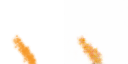

true		discriminator prediction
----------------------------------------
1		0.3476
0		0.2003
--------------------------------------------------
Epoch 1/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.712
 => Mean Loss of training at current step: 0.712

true vs generated stroke:


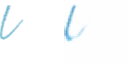

true		discriminator prediction
----------------------------------------
1		0.6708
0		0.6223
--------------------------------------------------
Epoch 1/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.709
 => Mean Loss of training at current step: 0.709

true vs generated stroke:


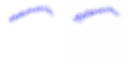

true		discriminator prediction
----------------------------------------
1		0.6016
0		0.4138
--------------------------------------------------
Epoch 1/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.707
 => Mean Loss of training at current step: 0.707

true vs generated stroke:


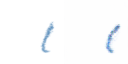

true		discriminator prediction
----------------------------------------
1		0.5483
0		0.4737
--------------------------------------------------
Epoch 1/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.706
 => Mean Loss of training at current step: 0.706

true vs generated stroke:


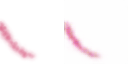

true		discriminator prediction
----------------------------------------
1		0.4211
0		0.6663
--------------------------------------------------
Epoch 1/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.704
 => Mean Loss of training at current step: 0.704

true vs generated stroke:


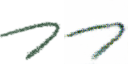

true		discriminator prediction
----------------------------------------
1		0.4307
0		0.4659
--------------------------------------------------
Epoch 1/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.703
 => Mean Loss of training at current step: 0.703

true vs generated stroke:


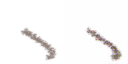

true		discriminator prediction
----------------------------------------
1		0.5803
0		0.385
--------------------------------------------------
Epoch 1/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.702
 => Mean Loss of training at current step: 0.702

true vs generated stroke:


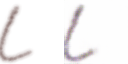

true		discriminator prediction
----------------------------------------
1		0.6122
0		0.4649
--------------------------------------------------
Epoch 1/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.701
 => Mean Loss of training at current step: 0.701

true vs generated stroke:


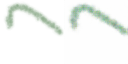

true		discriminator prediction
----------------------------------------
1		0.5333
0		0.4567
--------------------------------------------------
Epoch 1/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.699
 => Mean Loss of training at current step: 0.699

true vs generated stroke:


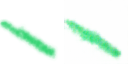

true		discriminator prediction
----------------------------------------
1		0.4529
0		0.6144
--------------------------------------------------
Epoch 1/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.698
 => Mean Loss of training at current step: 0.698

true vs generated stroke:


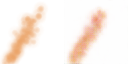

true		discriminator prediction
----------------------------------------
1		0.4662
0		0.6024
--------------------------------------------------
Epoch 1/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.697
 => Mean Loss of training at current step: 0.697

true vs generated stroke:


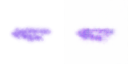

true		discriminator prediction
----------------------------------------
1		0.447
0		0.5607
--------------------------------------------------
Epoch 1/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.696
 => Mean Loss of training at current step: 0.696

true vs generated stroke:


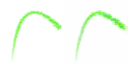

true		discriminator prediction
----------------------------------------
1		0.6361
0		0.5962
--------------------------------------------------
Epoch 1/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.695
 => Mean Loss of training at current step: 0.695

true vs generated stroke:


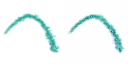

true		discriminator prediction
----------------------------------------
1		0.5876
0		0.3687
--------------------------------------------------
Epoch 1/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.694
 => Mean Loss of training at current step: 0.694

true vs generated stroke:


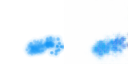

true		discriminator prediction
----------------------------------------
1		0.5284
0		0.4245
--------------------------------------------------
Epoch 1/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.693
 => Mean Loss of training at current step: 0.693

true vs generated stroke:


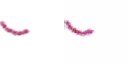

true		discriminator prediction
----------------------------------------
1		0.5256
0		0.5798
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1
----------------------------------------------------------------------------------------------------
Epoch 2/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.665
 => Mean Loss of training at current step: 0.692

true vs generated stroke:


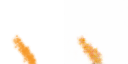

true		discriminator prediction
----------------------------------------
1		0.4913
0		0.4555
--------------------------------------------------
Epoch 2/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.675
 => Mean Loss of training at current step: 0.691

true vs generated stroke:


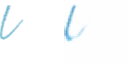

true		discriminator prediction
----------------------------------------
1		0.5473
0		0.465
--------------------------------------------------
Epoch 2/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.675
 => Mean Loss of training at current step: 0.690

true vs generated stroke:


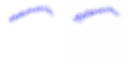

true		discriminator prediction
----------------------------------------
1		0.6377
0		0.4661
--------------------------------------------------
Epoch 2/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.673
 => Mean Loss of training at current step: 0.689

true vs generated stroke:


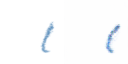

true		discriminator prediction
----------------------------------------
1		0.5777
0		0.5363
--------------------------------------------------
Epoch 2/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.672
 => Mean Loss of training at current step: 0.688

true vs generated stroke:


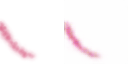

true		discriminator prediction
----------------------------------------
1		0.4778
0		0.53
--------------------------------------------------
Epoch 2/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.671
 => Mean Loss of training at current step: 0.687

true vs generated stroke:


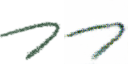

true		discriminator prediction
----------------------------------------
1		0.4949
0		0.3773
--------------------------------------------------
Epoch 2/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.670
 => Mean Loss of training at current step: 0.686

true vs generated stroke:


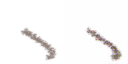

true		discriminator prediction
----------------------------------------
1		0.4488
0		0.5348
--------------------------------------------------
Epoch 2/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.669
 => Mean Loss of training at current step: 0.685

true vs generated stroke:


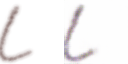

true		discriminator prediction
----------------------------------------
1		0.5293
0		0.4973
--------------------------------------------------
Epoch 2/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.668
 => Mean Loss of training at current step: 0.684

true vs generated stroke:


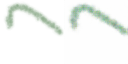

true		discriminator prediction
----------------------------------------
1		0.3591
0		0.6089
--------------------------------------------------
Epoch 2/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.667
 => Mean Loss of training at current step: 0.683

true vs generated stroke:


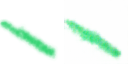

true		discriminator prediction
----------------------------------------
1		0.5158
0		0.2663
--------------------------------------------------
Epoch 2/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.666
 => Mean Loss of training at current step: 0.682

true vs generated stroke:


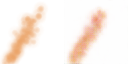

true		discriminator prediction
----------------------------------------
1		0.6412
0		0.5182
--------------------------------------------------
Epoch 2/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.665
 => Mean Loss of training at current step: 0.681

true vs generated stroke:


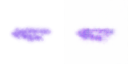

true		discriminator prediction
----------------------------------------
1		0.6092
0		0.3996
--------------------------------------------------
Epoch 2/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.663
 => Mean Loss of training at current step: 0.680

true vs generated stroke:


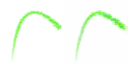

true		discriminator prediction
----------------------------------------
1		0.5887
0		0.4684
--------------------------------------------------
Epoch 2/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.662
 => Mean Loss of training at current step: 0.679

true vs generated stroke:


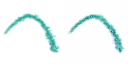

true		discriminator prediction
----------------------------------------
1		0.564
0		0.5532
--------------------------------------------------
Epoch 2/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.661
 => Mean Loss of training at current step: 0.678

true vs generated stroke:


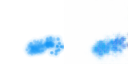

true		discriminator prediction
----------------------------------------
1		0.6195
0		0.5338
--------------------------------------------------
Epoch 2/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.660
 => Mean Loss of training at current step: 0.676

true vs generated stroke:


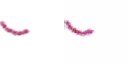

true		discriminator prediction
----------------------------------------
1		0.6198
0		0.4852
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2
----------------------------------------------------------------------------------------------------
Epoch 3/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.623
 => Mean Loss of training at current step: 0.676

true vs generated stroke:


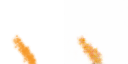

true		discriminator prediction
----------------------------------------
1		0.5125
0		0.5173
--------------------------------------------------
Epoch 3/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.633
 => Mean Loss of training at current step: 0.674

true vs generated stroke:


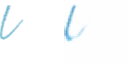

true		discriminator prediction
----------------------------------------
1		0.5245
0		0.3927
--------------------------------------------------
Epoch 3/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.635
 => Mean Loss of training at current step: 0.673

true vs generated stroke:


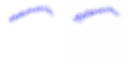

true		discriminator prediction
----------------------------------------
1		0.3779
0		0.4424
--------------------------------------------------
Epoch 3/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.633
 => Mean Loss of training at current step: 0.672

true vs generated stroke:


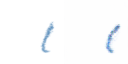

true		discriminator prediction
----------------------------------------
1		0.4847
0		0.417
--------------------------------------------------
Epoch 3/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.631
 => Mean Loss of training at current step: 0.671

true vs generated stroke:


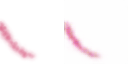

true		discriminator prediction
----------------------------------------
1		0.5648
0		0.6194
--------------------------------------------------
Epoch 3/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.630
 => Mean Loss of training at current step: 0.669

true vs generated stroke:


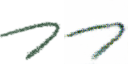

true		discriminator prediction
----------------------------------------
1		0.4865
0		0.2795
--------------------------------------------------
Epoch 3/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.628
 => Mean Loss of training at current step: 0.668

true vs generated stroke:


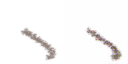

true		discriminator prediction
----------------------------------------
1		0.5332
0		0.4751
--------------------------------------------------
Epoch 3/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.625
 => Mean Loss of training at current step: 0.666

true vs generated stroke:


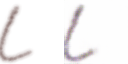

true		discriminator prediction
----------------------------------------
1		0.6869
0		0.3117
--------------------------------------------------
Epoch 3/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.624
 => Mean Loss of training at current step: 0.665

true vs generated stroke:


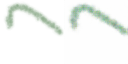

true		discriminator prediction
----------------------------------------
1		0.6091
0		0.3546
--------------------------------------------------
Epoch 3/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.622
 => Mean Loss of training at current step: 0.664

true vs generated stroke:


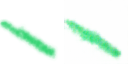

true		discriminator prediction
----------------------------------------
1		0.5852
0		0.4351
--------------------------------------------------
Epoch 3/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.620
 => Mean Loss of training at current step: 0.662

true vs generated stroke:


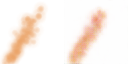

true		discriminator prediction
----------------------------------------
1		0.553
0		0.6362
--------------------------------------------------
Epoch 3/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.618
 => Mean Loss of training at current step: 0.661

true vs generated stroke:


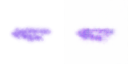

true		discriminator prediction
----------------------------------------
1		0.407
0		0.3115
--------------------------------------------------
Epoch 3/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.616
 => Mean Loss of training at current step: 0.659

true vs generated stroke:


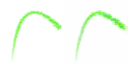

true		discriminator prediction
----------------------------------------
1		0.5304
0		0.5366
--------------------------------------------------
Epoch 3/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.614
 => Mean Loss of training at current step: 0.658

true vs generated stroke:


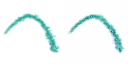

true		discriminator prediction
----------------------------------------
1		0.653
0		0.4436
--------------------------------------------------
Epoch 3/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.612
 => Mean Loss of training at current step: 0.656

true vs generated stroke:


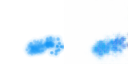

true		discriminator prediction
----------------------------------------
1		0.6179
0		0.4834
--------------------------------------------------
Epoch 3/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.610
 => Mean Loss of training at current step: 0.654

true vs generated stroke:


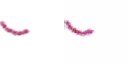

true		discriminator prediction
----------------------------------------
1		0.555
0		0.5944
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 3
----------------------------------------------------------------------------------------------------
Epoch 4/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.598
 => Mean Loss of training at current step: 0.653

true vs generated stroke:


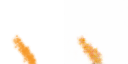

true		discriminator prediction
----------------------------------------
1		0.4604
0		0.3731
--------------------------------------------------
Epoch 4/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.566
 => Mean Loss of training at current step: 0.651

true vs generated stroke:


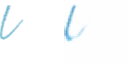

true		discriminator prediction
----------------------------------------
1		0.3993
0		0.5692
--------------------------------------------------
Epoch 4/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.566
 => Mean Loss of training at current step: 0.649

true vs generated stroke:


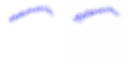

true		discriminator prediction
----------------------------------------
1		0.6709
0		0.5396
--------------------------------------------------
Epoch 4/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.562
 => Mean Loss of training at current step: 0.648

true vs generated stroke:


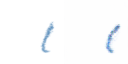

true		discriminator prediction
----------------------------------------
1		0.5417
0		0.305
--------------------------------------------------
Epoch 4/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.559
 => Mean Loss of training at current step: 0.646

true vs generated stroke:


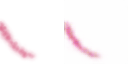

true		discriminator prediction
----------------------------------------
1		0.4318
0		0.3912
--------------------------------------------------
Epoch 4/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.556
 => Mean Loss of training at current step: 0.644

true vs generated stroke:


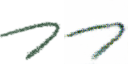

true		discriminator prediction
----------------------------------------
1		0.8405
0		0.3519
--------------------------------------------------
Epoch 4/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.552
 => Mean Loss of training at current step: 0.642

true vs generated stroke:


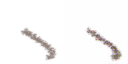

true		discriminator prediction
----------------------------------------
1		0.6135
0		0.4367
--------------------------------------------------
Epoch 4/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.548
 => Mean Loss of training at current step: 0.639

true vs generated stroke:


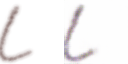

true		discriminator prediction
----------------------------------------
1		0.5803
0		0.36
--------------------------------------------------
Epoch 4/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.544
 => Mean Loss of training at current step: 0.637

true vs generated stroke:


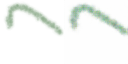

true		discriminator prediction
----------------------------------------
1		0.6234
0		0.4828
--------------------------------------------------
Epoch 4/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.540
 => Mean Loss of training at current step: 0.635

true vs generated stroke:


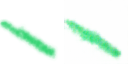

true		discriminator prediction
----------------------------------------
1		0.6459
0		0.444
--------------------------------------------------
Epoch 4/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.537
 => Mean Loss of training at current step: 0.633

true vs generated stroke:


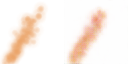

true		discriminator prediction
----------------------------------------
1		0.4477
0		0.5286
--------------------------------------------------
Epoch 4/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.532
 => Mean Loss of training at current step: 0.630

true vs generated stroke:


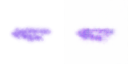

true		discriminator prediction
----------------------------------------
1		0.8656
0		0.4467
--------------------------------------------------
Epoch 4/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.528
 => Mean Loss of training at current step: 0.628

true vs generated stroke:


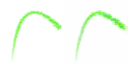

true		discriminator prediction
----------------------------------------
1		0.5406
0		0.4475
--------------------------------------------------
Epoch 4/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.525
 => Mean Loss of training at current step: 0.625

true vs generated stroke:


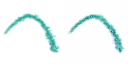

true		discriminator prediction
----------------------------------------
1		0.6337
0		0.2326
--------------------------------------------------
Epoch 4/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.520
 => Mean Loss of training at current step: 0.622

true vs generated stroke:


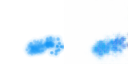

true		discriminator prediction
----------------------------------------
1		0.6969
0		0.3999
--------------------------------------------------
Epoch 4/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.516
 => Mean Loss of training at current step: 0.620

true vs generated stroke:


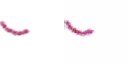

true		discriminator prediction
----------------------------------------
1		0.4717
0		0.2695
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 4
----------------------------------------------------------------------------------------------------
Epoch 5/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.435
 => Mean Loss of training at current step: 0.618

true vs generated stroke:


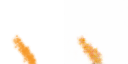

true		discriminator prediction
----------------------------------------
1		0.2193
0		0.3789
--------------------------------------------------
Epoch 5/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.430
 => Mean Loss of training at current step: 0.615

true vs generated stroke:


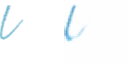

true		discriminator prediction
----------------------------------------
1		0.3213
0		0.4513
--------------------------------------------------
Epoch 5/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.429
 => Mean Loss of training at current step: 0.612

true vs generated stroke:


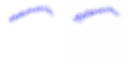

true		discriminator prediction
----------------------------------------
1		0.5943
0		0.4308
--------------------------------------------------
Epoch 5/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.420
 => Mean Loss of training at current step: 0.609

true vs generated stroke:


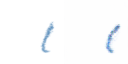

true		discriminator prediction
----------------------------------------
1		0.5291
0		0.3772
--------------------------------------------------
Epoch 5/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.414
 => Mean Loss of training at current step: 0.606

true vs generated stroke:


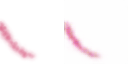

true		discriminator prediction
----------------------------------------
1		0.4722
0		0.4576
--------------------------------------------------
Epoch 5/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.407
 => Mean Loss of training at current step: 0.602

true vs generated stroke:


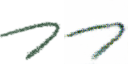

true		discriminator prediction
----------------------------------------
1		0.6088
0		0.3307
--------------------------------------------------
Epoch 5/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.400
 => Mean Loss of training at current step: 0.599

true vs generated stroke:


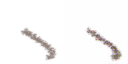

true		discriminator prediction
----------------------------------------
1		0.7279
0		0.3299
--------------------------------------------------
Epoch 5/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.393
 => Mean Loss of training at current step: 0.595

true vs generated stroke:


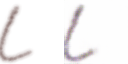

true		discriminator prediction
----------------------------------------
1		0.7619
0		0.4943
--------------------------------------------------
Epoch 5/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.386
 => Mean Loss of training at current step: 0.592

true vs generated stroke:


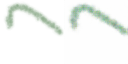

true		discriminator prediction
----------------------------------------
1		0.7997
0		0.6096
--------------------------------------------------
Epoch 5/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.379
 => Mean Loss of training at current step: 0.588

true vs generated stroke:


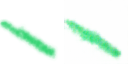

true		discriminator prediction
----------------------------------------
1		0.6204
0		0.2039
--------------------------------------------------
Epoch 5/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.372
 => Mean Loss of training at current step: 0.584

true vs generated stroke:


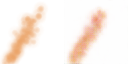

true		discriminator prediction
----------------------------------------
1		0.8057
0		0.375
--------------------------------------------------
Epoch 5/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.365
 => Mean Loss of training at current step: 0.580

true vs generated stroke:


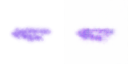

true		discriminator prediction
----------------------------------------
1		0.7418
0		0.151
--------------------------------------------------
Epoch 5/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.358
 => Mean Loss of training at current step: 0.576

true vs generated stroke:


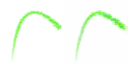

true		discriminator prediction
----------------------------------------
1		0.4371
0		0.287
--------------------------------------------------
Epoch 5/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.352
 => Mean Loss of training at current step: 0.572

true vs generated stroke:


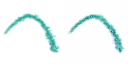

true		discriminator prediction
----------------------------------------
1		0.9275
0		0.1705
--------------------------------------------------
Epoch 5/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.344
 => Mean Loss of training at current step: 0.568

true vs generated stroke:


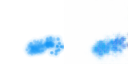

true		discriminator prediction
----------------------------------------
1		0.8441
0		0.2955
--------------------------------------------------
Epoch 5/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.337
 => Mean Loss of training at current step: 0.564

true vs generated stroke:


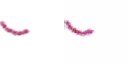

true		discriminator prediction
----------------------------------------
1		0.7762
0		0.1694
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 5
----------------------------------------------------------------------------------------------------
Epoch 6/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.193
 => Mean Loss of training at current step: 0.561

true vs generated stroke:


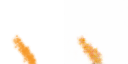

true		discriminator prediction
----------------------------------------
1		0.7137
0		0.0788
--------------------------------------------------
Epoch 6/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.199
 => Mean Loss of training at current step: 0.556

true vs generated stroke:


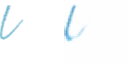

true		discriminator prediction
----------------------------------------
1		0.7669
0		0.0991
--------------------------------------------------
Epoch 6/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.196
 => Mean Loss of training at current step: 0.552

true vs generated stroke:


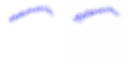

true		discriminator prediction
----------------------------------------
1		0.9075
0		0.2456
--------------------------------------------------
Epoch 6/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.188
 => Mean Loss of training at current step: 0.547

true vs generated stroke:


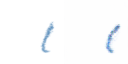

true		discriminator prediction
----------------------------------------
1		0.8576
0		0.0621
--------------------------------------------------
Epoch 6/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.182
 => Mean Loss of training at current step: 0.542

true vs generated stroke:


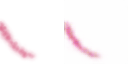

true		discriminator prediction
----------------------------------------
1		0.9016
0		0.2888
--------------------------------------------------
Epoch 6/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.174
 => Mean Loss of training at current step: 0.537

true vs generated stroke:


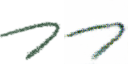

true		discriminator prediction
----------------------------------------
1		0.6699
0		0.0525
--------------------------------------------------
Epoch 6/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.166
 => Mean Loss of training at current step: 0.533

true vs generated stroke:


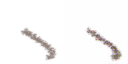

true		discriminator prediction
----------------------------------------
1		0.9734
0		0.1418
--------------------------------------------------
Epoch 6/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.159
 => Mean Loss of training at current step: 0.528

true vs generated stroke:


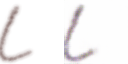

true		discriminator prediction
----------------------------------------
1		0.9671
0		0.2476
--------------------------------------------------
Epoch 6/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.152
 => Mean Loss of training at current step: 0.523

true vs generated stroke:


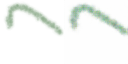

true		discriminator prediction
----------------------------------------
1		0.9305
0		0.1234
--------------------------------------------------
Epoch 6/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.147
 => Mean Loss of training at current step: 0.518

true vs generated stroke:


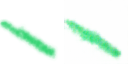

true		discriminator prediction
----------------------------------------
1		0.9497
0		0.0586
--------------------------------------------------
Epoch 6/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.141
 => Mean Loss of training at current step: 0.513

true vs generated stroke:


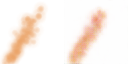

true		discriminator prediction
----------------------------------------
1		0.9286
0		0.0648
--------------------------------------------------
Epoch 6/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.135
 => Mean Loss of training at current step: 0.508

true vs generated stroke:


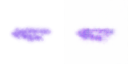

true		discriminator prediction
----------------------------------------
1		0.9463
0		0.1223
--------------------------------------------------
Epoch 6/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.130
 => Mean Loss of training at current step: 0.503

true vs generated stroke:


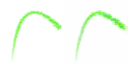

true		discriminator prediction
----------------------------------------
1		0.9621
0		0.0961
--------------------------------------------------
Epoch 6/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.125
 => Mean Loss of training at current step: 0.499

true vs generated stroke:


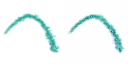

true		discriminator prediction
----------------------------------------
1		0.9812
0		0.2003
--------------------------------------------------
Epoch 6/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.120
 => Mean Loss of training at current step: 0.494

true vs generated stroke:


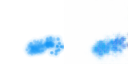

true		discriminator prediction
----------------------------------------
1		0.9864
0		0.0462
--------------------------------------------------
Epoch 6/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.115
 => Mean Loss of training at current step: 0.489

true vs generated stroke:


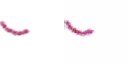

true		discriminator prediction
----------------------------------------
1		0.9748
0		0.015
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 6
----------------------------------------------------------------------------------------------------
Epoch 7/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.032
 => Mean Loss of training at current step: 0.486

true vs generated stroke:


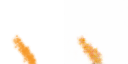

true		discriminator prediction
----------------------------------------
1		0.9315
0		0.0316
--------------------------------------------------
Epoch 7/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.038
 => Mean Loss of training at current step: 0.481

true vs generated stroke:


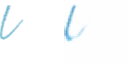

true		discriminator prediction
----------------------------------------
1		0.961
0		0.0497
--------------------------------------------------
Epoch 7/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.037
 => Mean Loss of training at current step: 0.477

true vs generated stroke:


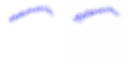

true		discriminator prediction
----------------------------------------
1		0.9695
0		0.0417
--------------------------------------------------
Epoch 7/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.034
 => Mean Loss of training at current step: 0.472

true vs generated stroke:


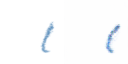

true		discriminator prediction
----------------------------------------
1		0.9841
0		0.0131
--------------------------------------------------
Epoch 7/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.033
 => Mean Loss of training at current step: 0.467

true vs generated stroke:


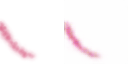

true		discriminator prediction
----------------------------------------
1		0.9855
0		0.0243
--------------------------------------------------
Epoch 7/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.031
 => Mean Loss of training at current step: 0.463

true vs generated stroke:


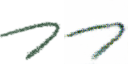

true		discriminator prediction
----------------------------------------
1		0.9883
0		0.0017
--------------------------------------------------
Epoch 7/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.029
 => Mean Loss of training at current step: 0.458

true vs generated stroke:


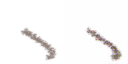

true		discriminator prediction
----------------------------------------
1		0.9943
0		0.0079
--------------------------------------------------
Epoch 7/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.027
 => Mean Loss of training at current step: 0.454

true vs generated stroke:


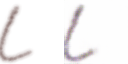

true		discriminator prediction
----------------------------------------
1		0.9994
0		0.0285
--------------------------------------------------
Epoch 7/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.025
 => Mean Loss of training at current step: 0.450

true vs generated stroke:


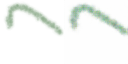

true		discriminator prediction
----------------------------------------
1		0.9838
0		0.0382
--------------------------------------------------
Epoch 7/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.024
 => Mean Loss of training at current step: 0.446

true vs generated stroke:


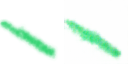

true		discriminator prediction
----------------------------------------
1		0.9966
0		0.0029
--------------------------------------------------
Epoch 7/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.023
 => Mean Loss of training at current step: 0.441

true vs generated stroke:


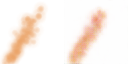

true		discriminator prediction
----------------------------------------
1		0.9923
0		0.0157
--------------------------------------------------
Epoch 7/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.022
 => Mean Loss of training at current step: 0.437

true vs generated stroke:


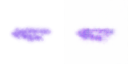

true		discriminator prediction
----------------------------------------
1		0.9804
0		0.0178
--------------------------------------------------
Epoch 7/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.021
 => Mean Loss of training at current step: 0.433

true vs generated stroke:


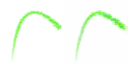

true		discriminator prediction
----------------------------------------
1		0.9883
0		0.0123
--------------------------------------------------
Epoch 7/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.020
 => Mean Loss of training at current step: 0.429

true vs generated stroke:


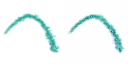

true		discriminator prediction
----------------------------------------
1		0.9982
0		0.0103
--------------------------------------------------
Epoch 7/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.019
 => Mean Loss of training at current step: 0.425

true vs generated stroke:


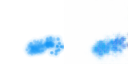

true		discriminator prediction
----------------------------------------
1		0.9993
0		0.0024
--------------------------------------------------
Epoch 7/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.018
 => Mean Loss of training at current step: 0.421

true vs generated stroke:


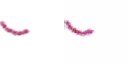

true		discriminator prediction
----------------------------------------
1		0.9942
0		0.0033
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 7
----------------------------------------------------------------------------------------------------
Epoch 8/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.419

true vs generated stroke:


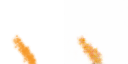

true		discriminator prediction
----------------------------------------
1		0.9958
0		0.0017
--------------------------------------------------
Epoch 8/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.004
 => Mean Loss of training at current step: 0.415

true vs generated stroke:


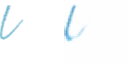

true		discriminator prediction
----------------------------------------
1		0.9979
0		0.0021
--------------------------------------------------
Epoch 8/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.004
 => Mean Loss of training at current step: 0.412

true vs generated stroke:


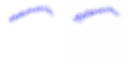

true		discriminator prediction
----------------------------------------
1		0.9973
0		0.0027
--------------------------------------------------
Epoch 8/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.004
 => Mean Loss of training at current step: 0.408

true vs generated stroke:


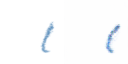

true		discriminator prediction
----------------------------------------
1		0.9976
0		0.0025
--------------------------------------------------
Epoch 8/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.404

true vs generated stroke:


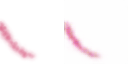

true		discriminator prediction
----------------------------------------
1		0.9996
0		0.0031
--------------------------------------------------
Epoch 8/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.401

true vs generated stroke:


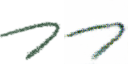

true		discriminator prediction
----------------------------------------
1		0.9974
0		0.0003
--------------------------------------------------
Epoch 8/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.397

true vs generated stroke:


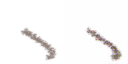

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0008
--------------------------------------------------
Epoch 8/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.394

true vs generated stroke:


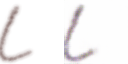

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.003
--------------------------------------------------
Epoch 8/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.391

true vs generated stroke:


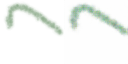

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0007
--------------------------------------------------
Epoch 8/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.003
 => Mean Loss of training at current step: 0.387

true vs generated stroke:


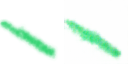

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0008
--------------------------------------------------
Epoch 8/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.384

true vs generated stroke:


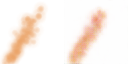

true		discriminator prediction
----------------------------------------
1		0.9981
0		0.0029
--------------------------------------------------
Epoch 8/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.381

true vs generated stroke:


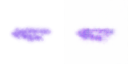

true		discriminator prediction
----------------------------------------
1		0.9986
0		0.0017
--------------------------------------------------
Epoch 8/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.378

true vs generated stroke:


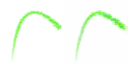

true		discriminator prediction
----------------------------------------
1		0.9987
0		0.0018
--------------------------------------------------
Epoch 8/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.375

true vs generated stroke:


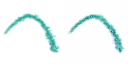

true		discriminator prediction
----------------------------------------
1		0.9997
0		0.0007
--------------------------------------------------
Epoch 8/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.372

true vs generated stroke:


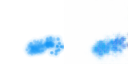

true		discriminator prediction
----------------------------------------
1		0.9997
0		0.0011
--------------------------------------------------
Epoch 8/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.002
 => Mean Loss of training at current step: 0.369

true vs generated stroke:


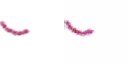

true		discriminator prediction
----------------------------------------
1		0.9992
0		0.0008
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 8
----------------------------------------------------------------------------------------------------
Epoch 9/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.367

true vs generated stroke:


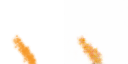

true		discriminator prediction
----------------------------------------
1		0.9991
0		0.0008
--------------------------------------------------
Epoch 9/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.364

true vs generated stroke:


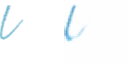

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0005
--------------------------------------------------
Epoch 9/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.361

true vs generated stroke:


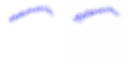

true		discriminator prediction
----------------------------------------
1		0.9996
0		0.0009
--------------------------------------------------
Epoch 9/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.358

true vs generated stroke:


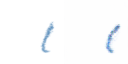

true		discriminator prediction
----------------------------------------
1		0.9997
0		0.0009
--------------------------------------------------
Epoch 9/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.356

true vs generated stroke:


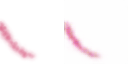

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0001
--------------------------------------------------
Epoch 9/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.353

true vs generated stroke:


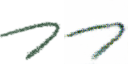

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0
--------------------------------------------------
Epoch 9/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.350

true vs generated stroke:


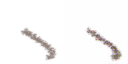

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0001
--------------------------------------------------
Epoch 9/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.347

true vs generated stroke:


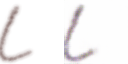

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0002
--------------------------------------------------
Epoch 9/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.345

true vs generated stroke:


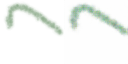

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
Epoch 9/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.342

true vs generated stroke:


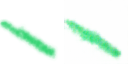

true		discriminator prediction
----------------------------------------
1		0.9997
0		0.0
--------------------------------------------------
Epoch 9/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.340

true vs generated stroke:


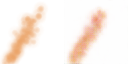

true		discriminator prediction
----------------------------------------
1		0.9996
0		0.0003
--------------------------------------------------
Epoch 9/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.337

true vs generated stroke:


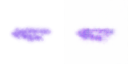

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0001
--------------------------------------------------
Epoch 9/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.335

true vs generated stroke:


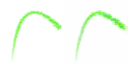

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0004
--------------------------------------------------
Epoch 9/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.332

true vs generated stroke:


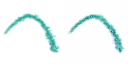

true		discriminator prediction
----------------------------------------
1		0.9998
0		0.0002
--------------------------------------------------
Epoch 9/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.330

true vs generated stroke:


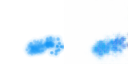

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0008
--------------------------------------------------
Epoch 9/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.328

true vs generated stroke:


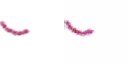

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 9
----------------------------------------------------------------------------------------------------
Epoch 10/10 | Sample 1/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.326

true vs generated stroke:


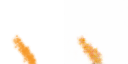

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 51/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.324

true vs generated stroke:


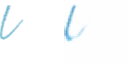

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 101/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.322

true vs generated stroke:


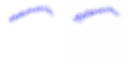

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 151/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.319

true vs generated stroke:


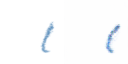

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 201/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.317

true vs generated stroke:


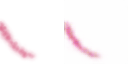

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 251/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.315

true vs generated stroke:


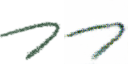

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 301/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.313

true vs generated stroke:


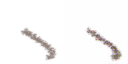

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 351/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.311

true vs generated stroke:


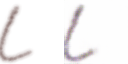

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 401/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.309

true vs generated stroke:


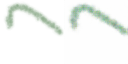

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 451/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.307

true vs generated stroke:


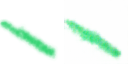

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 501/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.304

true vs generated stroke:


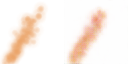

true		discriminator prediction
----------------------------------------
1		0.9999
0		0.0001
--------------------------------------------------
Epoch 10/10 | Sample 551/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.302

true vs generated stroke:


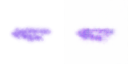

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 601/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.301

true vs generated stroke:


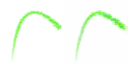

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0002
--------------------------------------------------
Epoch 10/10 | Sample 651/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.299

true vs generated stroke:


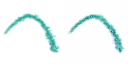

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 701/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.297

true vs generated stroke:


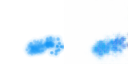

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
Epoch 10/10 | Sample 751/782
 => Mean Loss of epoch at current step: 0.000
 => Mean Loss of training at current step: 0.295

true vs generated stroke:


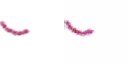

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 10
----------------------------------------------------------------------------------------------------

END OF TRAINING: model is saved to /content/gdrive/MyDrive/NaturalPainters/models/discriminator/discriminator_2022-02-16 21:27:00_10e_877seed.pth.


In [29]:
# set either repeated or random experiment
torch.manual_seed(SEED)

# set hyperparameters: right pannel provides the playground
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    p = 0.15 #@param {type:"slider", min: 0.0, max:1.0, step:0.025}
    batch_size = 128 #@param {type: "slider", min:8, max:512, step:8}
    lr = 2e-6 #@param {type:"number"}
    betas = (0.3, 0.7) #@param
    epochs = 10 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 50 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

# define device for training
gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

# get the dataset
current_npz = 'episodes_1.npz'
dataset = create_dataset(current_npz)

# create the loader to train by batches
dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

# create model instance of Discriminator
discriminator = Discriminator(hparams.img_channels, 
                              hparams.img_height,
                              hparams.p)

discriminator.to(device)

# create model instance of Generator
generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

# load the Generator's learnt parameters
generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))

# freezing the weights
for param in generator.parameters():
    param.requires_grad = False

# evaluation regime, no need to re-train
generator.to(device).eval()

# create an instance of optimizer
optimizer = optim.Adam(discriminator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

# define loss function that measures the Binary Cross Entropy 
loss = F.binary_cross_entropy

# transformations on strokes
strokes_tfms = T.Compose([T.Lambda(lambda x: x.float()),
                          T.Lambda(lambda x: x.div_(255))])

# create model instance of Trainer
trainer = Trainer(strokes_tfms,
                  generator,
                  discriminator,
                  optimizer,
                  loss,
                  epochs = hparams.epochs,
                  gpu = gpu)

# generate paths for saving
disc_path, loss_path = generate_path(hparams.epochs)
# call the training method with the desired saving path
train_history = trainer.train(dataloader, 
                              print_interval = hparams.print_interval,
                              save_model_path = disc_path)

## **Loss History**

In [30]:
# plot and save train loss
def plot_loss(save_loss_path = '', model_name = 'Model',
              xlim = [], ylim = [], color = 'darkcyan', alpha = 0.5,
              epochs = 15):

    fig, axs = plt.subplots()

    plt.plot(train_history['train_loss'], '-', color = color, alpha = alpha)
    plt.plot(train_history['mean_train_loss'], '--', color = color)

    plt.title(f'{model_name} loss collected over {epochs} epochs')
    plt.ylabel('Loss')
    plt.xlabel('Step (dataset size / batch size * num epochs)')

    if xlim != []:
        plt.xlim(xlim)
    if ylim != []:
        plt.ylim(ylim)

    plt.legend(['train loss', 'mean train loss'], loc = 'upper right')

    if save_loss_path != '':
        fig.savefig(save_loss_path, bbox_inches = 'tight')

    plt.show()

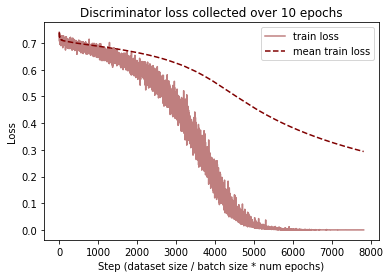

In [32]:
plot_loss(loss_path, 'Discriminator',
          color = 'maroon', 
          epochs = hparams.epochs)